In [1]:
!pip install torch torchvision torchaudio
!pip install torch_geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attempti

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

In [3]:
train_data = np.load('/kaggle/input/cse-251-b-2025/train.npz')['data']
test_data = np.load('/kaggle/input/cse-251-b-2025/test_input.npz')['data']

In [4]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [9]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [10]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

In [ ]:
model = LSTM().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
early_stopping_patience = 10
best_val_loss = float('inf')
no_improvement = 0
criterion = nn.MSELoss()

In [15]:
for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()
    
    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            # show MAE and MSE with unnormalized data
            # unscale 
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    scheduler.step()
    # scheduler.step(val_loss)
    
    tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break

Epoch:   1%|          | 1/100 [00:12<19:52, 12.04s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.7552 | val normalized MSE   0.5112, | val MAE   2.7033 | val MSE  25.0508


Epoch:   2%|▏         | 2/100 [00:23<19:18, 11.82s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.4672 | val normalized MSE   0.3915, | val MAE   2.2881 | val MSE  19.1854


Epoch:   3%|▎         | 3/100 [00:35<19:14, 11.90s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.3943 | val normalized MSE   0.3564, | val MAE   2.1769 | val MSE  17.4642


Epoch:   4%|▍         | 4/100 [00:47<18:51, 11.79s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.3692 | val normalized MSE   0.3419, | val MAE   2.1890 | val MSE  16.7530


Epoch:   5%|▌         | 5/100 [00:58<18:26, 11.65s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.3472 | val normalized MSE   0.3093, | val MAE   2.0168 | val MSE  15.1558


Epoch:   6%|▌         | 6/100 [01:14<20:24, 13.03s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.3224 | val normalized MSE   0.3009, | val MAE   2.0609 | val MSE  14.7420


Epoch:   7%|▋         | 7/100 [01:31<22:18, 14.39s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.3082 | val normalized MSE   0.2730, | val MAE   1.8394 | val MSE  13.3792


Epoch:   8%|▊         | 8/100 [01:48<23:19, 15.21s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2935 | val normalized MSE   0.2847, | val MAE   1.9193 | val MSE  13.9483


Epoch:   9%|▉         | 9/100 [02:05<24:02, 15.86s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2846 | val normalized MSE   0.2602, | val MAE   1.8778 | val MSE  12.7516


Epoch:  10%|█         | 10/100 [02:22<24:22, 16.25s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.2693 | val normalized MSE   0.2483, | val MAE   1.7522 | val MSE  12.1682


Epoch:  11%|█         | 11/100 [02:40<24:31, 16.53s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2670 | val normalized MSE   0.2386, | val MAE   1.7546 | val MSE  11.6896


Epoch:  12%|█▏        | 12/100 [02:57<24:23, 16.63s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2560 | val normalized MSE   0.2420, | val MAE   1.7400 | val MSE  11.8569


Epoch:  13%|█▎        | 13/100 [03:14<24:20, 16.79s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2489 | val normalized MSE   0.2390, | val MAE   1.7305 | val MSE  11.7112


Epoch:  14%|█▍        | 14/100 [03:31<24:07, 16.83s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2434 | val normalized MSE   0.2231, | val MAE   1.7157 | val MSE  10.9320


Epoch:  15%|█▌        | 15/100 [03:48<24:01, 16.96s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2382 | val normalized MSE   0.2131, | val MAE   1.5769 | val MSE  10.4395


Epoch:  16%|█▌        | 16/100 [04:05<23:44, 16.96s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2358 | val normalized MSE   0.2292, | val MAE   1.7184 | val MSE  11.2313


Epoch:  17%|█▋        | 17/100 [04:24<24:18, 17.57s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2339 | val normalized MSE   0.2224, | val MAE   1.7676 | val MSE  10.8969


Epoch:  18%|█▊        | 18/100 [04:41<23:58, 17.54s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2319 | val normalized MSE   0.2120, | val MAE   1.5978 | val MSE  10.3904


Epoch:  19%|█▉        | 19/100 [04:59<23:34, 17.46s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2272 | val normalized MSE   0.2124, | val MAE   1.5793 | val MSE  10.4097


Epoch:  20%|██        | 20/100 [05:16<23:16, 17.45s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2239 | val normalized MSE   0.2162, | val MAE   1.6391 | val MSE  10.5961


Epoch:  21%|██        | 21/100 [05:33<22:52, 17.37s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2080 | val normalized MSE   0.1957, | val MAE   1.4326 | val MSE   9.5910


Epoch:  22%|██▏       | 22/100 [05:50<22:31, 17.33s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.2032 | val normalized MSE   0.1969, | val MAE   1.4971 | val MSE   9.6471


Epoch:  23%|██▎       | 23/100 [06:08<22:11, 17.29s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.2025 | val normalized MSE   0.1968, | val MAE   1.4392 | val MSE   9.6448


Epoch:  24%|██▍       | 24/100 [06:25<22:00, 17.37s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.2014 | val normalized MSE   0.1935, | val MAE   1.4416 | val MSE   9.4821


Epoch:  25%|██▌       | 25/100 [06:43<21:56, 17.55s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.2011 | val normalized MSE   0.1963, | val MAE   1.4481 | val MSE   9.6200


Epoch:  26%|██▌       | 26/100 [07:02<22:07, 17.94s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.2010 | val normalized MSE   0.1972, | val MAE   1.4810 | val MSE   9.6633


Epoch:  27%|██▋       | 27/100 [07:19<21:39, 17.81s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.1995 | val normalized MSE   0.1969, | val MAE   1.4910 | val MSE   9.6466


Epoch:  28%|██▊       | 28/100 [07:37<21:14, 17.70s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.1988 | val normalized MSE   0.1949, | val MAE   1.4901 | val MSE   9.5518


Epoch:  29%|██▉       | 29/100 [07:54<20:44, 17.53s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.1978 | val normalized MSE   0.1934, | val MAE   1.4885 | val MSE   9.4786


Epoch:  30%|███       | 30/100 [08:11<20:24, 17.50s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.1999 | val normalized MSE   0.1918, | val MAE   1.5152 | val MSE   9.3976


Epoch:  31%|███       | 31/100 [08:29<20:05, 17.46s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.1969 | val normalized MSE   0.2000, | val MAE   1.4859 | val MSE   9.8019


Epoch:  32%|███▏      | 32/100 [08:46<19:37, 17.32s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.1968 | val normalized MSE   0.1939, | val MAE   1.4726 | val MSE   9.5019


Epoch:  33%|███▎      | 33/100 [09:04<19:40, 17.62s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.1957 | val normalized MSE   0.1952, | val MAE   1.5258 | val MSE   9.5663


Epoch:  34%|███▍      | 34/100 [09:21<19:15, 17.50s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.1956 | val normalized MSE   0.1963, | val MAE   1.5113 | val MSE   9.6207


Epoch:  35%|███▌      | 35/100 [09:39<18:59, 17.53s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.1960 | val normalized MSE   0.1880, | val MAE   1.4514 | val MSE   9.2105


Epoch:  36%|███▌      | 36/100 [09:57<18:43, 17.56s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.1946 | val normalized MSE   0.1957, | val MAE   1.4949 | val MSE   9.5876


Epoch:  37%|███▋      | 37/100 [10:14<18:30, 17.63s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.1956 | val normalized MSE   0.1946, | val MAE   1.4938 | val MSE   9.5330


Epoch:  38%|███▊      | 38/100 [10:32<18:03, 17.47s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.1945 | val normalized MSE   0.1930, | val MAE   1.5027 | val MSE   9.4563


Epoch:  39%|███▉      | 39/100 [10:49<17:44, 17.44s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.1933 | val normalized MSE   0.1947, | val MAE   1.4698 | val MSE   9.5383


Epoch:  40%|████      | 40/100 [11:06<17:21, 17.36s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.1930 | val normalized MSE   0.1941, | val MAE   1.4613 | val MSE   9.5127


Epoch:  41%|████      | 41/100 [11:23<17:05, 17.37s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1868 | val normalized MSE   0.1917, | val MAE   1.4689 | val MSE   9.3918


Epoch:  42%|████▏     | 42/100 [11:41<16:46, 17.35s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1856 | val normalized MSE   0.1901, | val MAE   1.4237 | val MSE   9.3153


Epoch:  43%|████▎     | 43/100 [11:58<16:26, 17.31s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1863 | val normalized MSE   0.1871, | val MAE   1.4320 | val MSE   9.1687


Epoch:  44%|████▍     | 44/100 [12:15<16:11, 17.36s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1850 | val normalized MSE   0.1868, | val MAE   1.4086 | val MSE   9.1512


Epoch:  45%|████▌     | 45/100 [12:33<15:54, 17.35s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1855 | val normalized MSE   0.1889, | val MAE   1.4516 | val MSE   9.2554


Epoch:  46%|████▌     | 46/100 [12:50<15:38, 17.38s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1838 | val normalized MSE   0.1863, | val MAE   1.4087 | val MSE   9.1293


Epoch:  47%|████▋     | 47/100 [13:08<15:19, 17.36s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1856 | val normalized MSE   0.1851, | val MAE   1.4038 | val MSE   9.0721


Epoch:  48%|████▊     | 48/100 [13:25<15:07, 17.46s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1848 | val normalized MSE   0.1878, | val MAE   1.4266 | val MSE   9.2031


Epoch:  49%|████▉     | 49/100 [13:43<14:49, 17.45s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1840 | val normalized MSE   0.1892, | val MAE   1.4604 | val MSE   9.2691


Epoch:  50%|█████     | 50/100 [14:00<14:37, 17.56s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1838 | val normalized MSE   0.1862, | val MAE   1.4222 | val MSE   9.1232


Epoch:  51%|█████     | 51/100 [14:18<14:23, 17.62s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1834 | val normalized MSE   0.1879, | val MAE   1.4085 | val MSE   9.2071


Epoch:  52%|█████▏    | 52/100 [14:38<14:43, 18.40s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1831 | val normalized MSE   0.1866, | val MAE   1.4391 | val MSE   9.1436


Epoch:  53%|█████▎    | 53/100 [14:56<14:17, 18.23s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1842 | val normalized MSE   0.1852, | val MAE   1.4067 | val MSE   9.0757


Epoch:  54%|█████▍    | 54/100 [15:14<13:49, 18.03s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1832 | val normalized MSE   0.1873, | val MAE   1.4247 | val MSE   9.1782


Epoch:  55%|█████▌    | 55/100 [15:32<13:26, 17.92s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1826 | val normalized MSE   0.1879, | val MAE   1.4329 | val MSE   9.2052


Epoch:  56%|█████▌    | 56/100 [15:49<12:58, 17.68s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1829 | val normalized MSE   0.1874, | val MAE   1.4161 | val MSE   9.1805


Epoch:  56%|█████▌    | 56/100 [16:06<12:39, 17.26s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1819 | val normalized MSE   0.1888, | val MAE   1.4462 | val MSE   9.2493
Early stop!


In [16]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

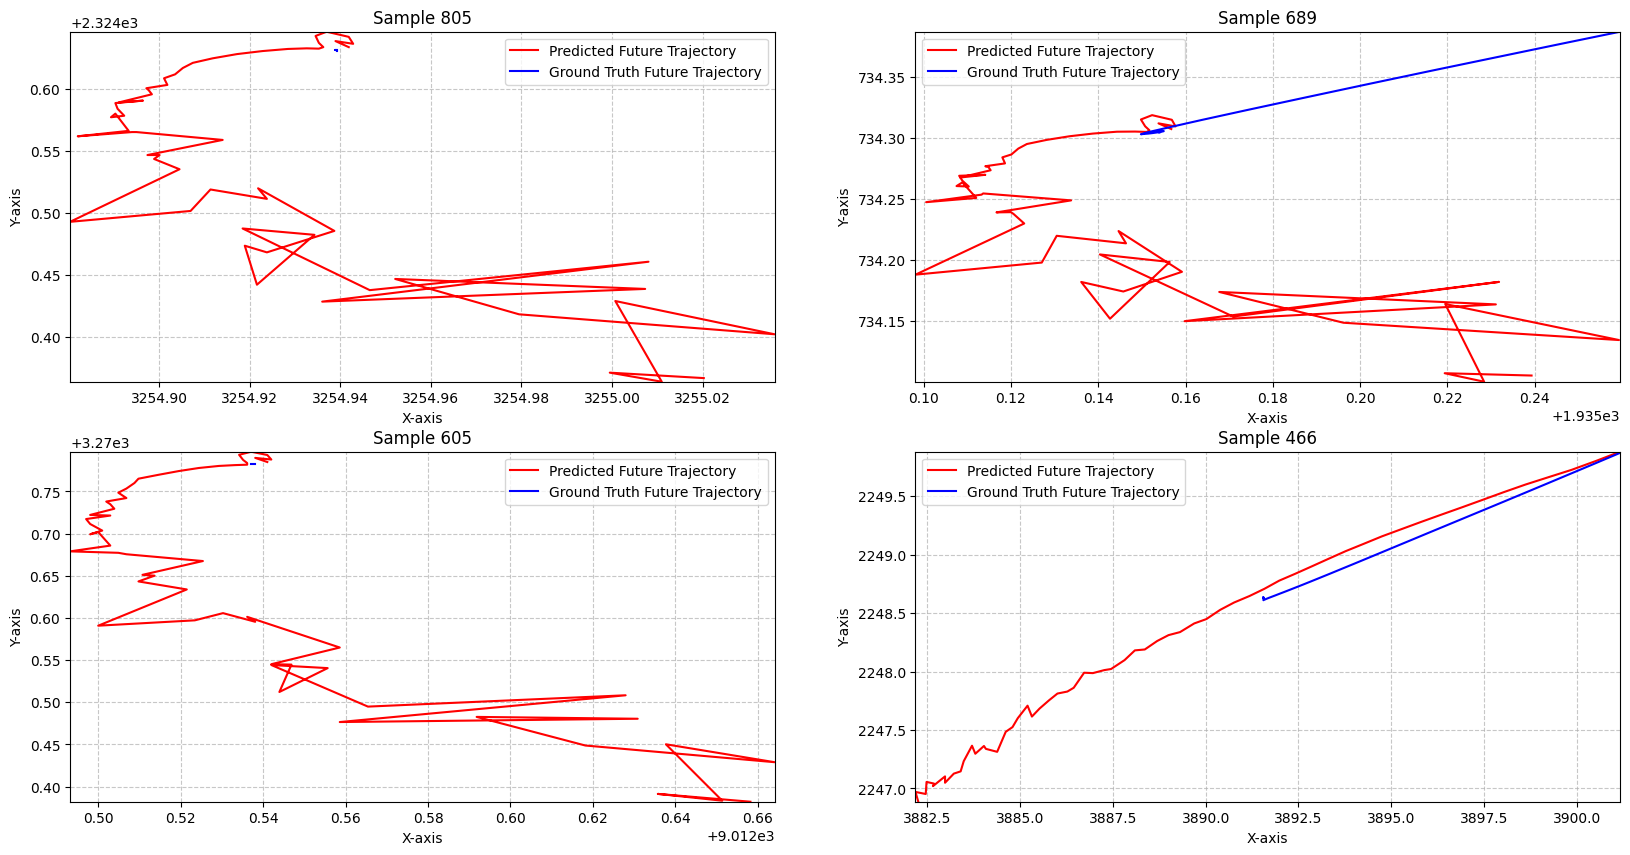

In [17]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

In [18]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
model = LSTM().to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)